# Imports

In [69]:
import sys
import pathlib
import joblib
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

if pathlib.Path().parent.resolve().absolute().as_posix() not in sys.path:
    sys.path.append(pathlib.Path().parent.resolve().absolute().as_posix())

from pilot import Pilot, ensemble

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [3]:
def highlight(data, kind='max', color='black', background_color='lightgreen'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'color: {}; background-color: {}'.format(color, background_color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        if kind == 'max':
            highlight = data == data.max()
        elif kind == 'min':
            highlight = data == data.min()
        return [attr if v else '' for v in highlight]
    else:  # from .apply(axis=None)
        if kind == 'max':
            highlight = data == data.max().max()
        elif kind == 'min':
            highlight = data == data.min().min()
        return pd.DataFrame(np.where(highlight, attr, ''),
                            index=data.index, columns=data.columns)

# Load data

In [4]:
DATAPATH = pathlib.Path().absolute() / 'Data'
datasets = {
    'abalone': {'categorical': [0]}, # sex
    'airfoil': {'categorical': [-1]},
    'Bias_correction_ucl': {'categorical': [0]}, # station 
    'bodyfat_preprocessed': {'categorical': [-1]},
    'boston': {'categorical': [3]}, # Charles river dummy
    'communities': {'categorical': [-1]}, # 119 = LemasGangUnitDeploy
    'concrete': {'categorical': [-1]},
    'diabetes': {'categorical': [-1]},
    'electricity': {'categorical': [-1]},
    'energy': {'categorical': [5]}, # Orientation (X6)
    'ga_preprocessed': {'categorical': [6]}, # Research
    'housing': {'categorical': [-1]},
    'ozone_preprocessed': {'categorical': [10, 11]},
    'residential': {'categorical': [-1]},
    'ribo_preprocessed': {'categorical': [-1]},
    'SeoulBikeData': {'categorical': [-1]}, # 10 = seasons
    'skills': {'categorical': [-1]},
    'superconductor': {'categorical': [-1]},
    'Walmart_preprocessed': {'categorical': [0]},
    'wine': {'categorical': [-1]}
}

In [5]:
for d in datasets:
    df = pd.read_csv(DATAPATH / f'{d}.csv')
    X = df.drop(columns='target').values
    y = df['target'].values
    datasets[d]['data'] = X, y

# Fit baseline model

In [13]:
for d, data in datasets.items():
    model = Pilot.PILOT()
    tree = DecisionTreeRegressor(max_depth=12, min_samples_leaf=5, min_samples_split=10)
    X, y = data['data']
    model.fit(X, y, categorical=np.array(data['categorical']))
    tree.fit(X, y)
    print(
        d, 
        round(r2_score(y, model.predict(X)), 2),
        round(r2_score(y, tree.predict(X)), 2)
    )
    

SystemError: CPUDispatcher(<function best_split at 0x7f7cec5d03a0>) returned a result with an exception set

# Hyperparameter tuning : truncation factor

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}
for d, data in datasets.items():
    if d == 'superconductor':
        continue
    pilot = GridSearchCV(estimator=Pilot.PILOT(), param_grid={'max_depth': [10], 'truncation_factor': [1, 1.5, 2, 2.5, 3]}, scoring='r2', cv=cv)
    tree = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid={'max_depth': [10]}, scoring='r2', cv=cv)
    lr = GridSearchCV(estimator=LinearRegression(), param_grid={}, scoring='r2', cv=cv)
    X, y = data['data']
    pilot.fit(X, y, categorical=np.array(data['categorical']))
    tree.fit(X, y)
    lr.fit(X, y)
    print(
        d, 
        round(pilot.best_score_, 2),
        round(tree.best_score_, 2),
        round(lr.best_score_, 2)
    )
    results[d] = pilot.cv_results_

abalone 0.53 0.3 0.52
airfoil 0.78 0.83 0.51
Bias_correction_ucl 0.84 0.81 0.78
bodyfat_preprocessed 0.61 0.31 0.64
boston 0.81 0.74 0.72
communities 0.63 0.3 -8.25
concrete 0.86 0.84 0.6
diabetes 0.43 -0.15 0.48
electricity 0.87 0.73 0.65
energy 0.96 0.95 0.89
ga_preprocessed 0.78 0.62 0.81
housing 0.8 0.69 0.6
ozone_preprocessed 0.62 0.29 0.67
residential 0.96 0.91 0.8
ribo_preprocessed 0.21 -0.72 0.59
SeoulBikeData 0.85 0.84 0.54
skills 0.57 0.3 0.56
Walmart_preprocessed 0.94 0.92 0.15
wine 0.35 0.21 0.27


In [ ]:
df = pd.concat([
    pd.DataFrame(results[d])[['param_truncation_factor', *[f'split{i}_test_score' for i in range(5)]]].melt(
        id_vars='param_truncation_factor'
    ).groupby('param_truncation_factor')['value'].mean().rename(d)
    for d in results
    ], axis=1).T

df

param_truncation_factor,1.0,1.5,2.0,2.5,3.0
abalone,0.525322,0.525322,0.525322,0.525322,0.525322
airfoil,0.783487,0.783027,0.783027,0.783027,0.783027
Bias_correction_ucl,0.842617,0.842626,0.842626,0.842626,0.842626
bodyfat_preprocessed,0.599459,0.612977,0.612977,0.612977,0.612977
boston,0.807326,0.794964,0.785967,0.785967,0.785967
communities,0.627817,0.629537,0.629537,0.629537,0.629537
concrete,0.862072,0.860658,0.860658,0.860658,0.860658
diabetes,0.432493,0.432500,0.432500,0.432500,0.432500
electricity,0.872879,0.871049,0.871049,0.871049,0.871049
energy,0.964247,0.964247,0.964247,0.964247,0.964247


In [ ]:
df.style.apply(partial(highlight, kind='max'), axis=1).format('{:.3f}')


param_truncation_factor,1.000000,1.500000,2.000000,2.500000,3.000000
abalone,0.525,0.525,0.525,0.525,0.525
airfoil,0.783,0.783,0.783,0.783,0.783
Bias_correction_ucl,0.843,0.843,0.843,0.843,0.843
bodyfat_preprocessed,0.599,0.613,0.613,0.613,0.613
boston,0.807,0.795,0.786,0.786,0.786
communities,0.628,0.630,0.630,0.630,0.630
concrete,0.862,0.861,0.861,0.861,0.861
diabetes,0.432,0.432,0.432,0.432,0.432
electricity,0.873,0.871,0.871,0.871,0.871
energy,0.964,0.964,0.964,0.964,0.964



# Hyperparameter tuning: Random Forest

## Investigate max depth and min_sample_split

### Run grid

In [ ]:
OUTPUTPATH = pathlib.Path().absolute() / 'Output'

In [ ]:
results = {}
for i, (d, data) in enumerate(datasets.items()):
    print(i)
    if d == 'superconductor':
        continue
    pilot = GridSearchCV(
        estimator=ensemble.RandomForestPilot(),
        param_grid={
            'n_estimators': [50],
            'max_depth': [2, 10],
            'truncation_factor': [1.5],
            'min_sample_split': [2, 10],
            'min_sample_leaf':  [1],
            'n_features': [1.0]
        }, 
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    tree = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'n_estimators': [50],
            'max_depth': [2, 10],
            'min_samples_split': [2, 10],
            'min_samples_leaf':  [1],
            'max_features': [1.0]
        },
        scoring='neg_mean_squared_error', 
        cv=5,
        n_jobs=-1
    )

    X, y = data['data']
    
    pilot.fit(X, y, categorical_idx=np.array(data['categorical']))
    tree.fit(X, y)

    
    print(d, round(pilot.best_score_, 2), round(tree.best_score_, 2))
    
    results[d] = {'pilot': pilot.cv_results_, 'rf': tree.cv_results_}
    joblib.dump(results, OUTPUTPATH / 'rf_gridsearch_v2.pkl')

### Rerun on Electricity,  Walmart, Boston, Abalone, Communities, Housing, Ribo

After adding rel_tolerance parameter to avoid recursion errors

In [ ]:
OUTPUTPATH = pathlib.Path().absolute() / 'Output'

In [ ]:
results =  joblib.load(OUTPUTPATH / 'rf_gridsearch_v3.pkl')
results.keys()

dict_keys(['electricity', 'Walmart_preprocessed', 'boston', 'abalone', 'communities', 'housing', 'ribo_preprocessed'])

In [ ]:
# datasets_selected = ['electricity', 'Walmart_preprocessed', 'boston', 'abalone', 'communities', 'housing', 'ribo_preprocessed']
datasets_selected = ['ribo_preprocessed']
# results = {}
for i, d in enumerate(datasets_selected):
    print(i)
    data = datasets[d]
    if d == 'superconductor':
        continue
    pilot = GridSearchCV(
        estimator=ensemble.RandomForestPilot(),
        param_grid={
            'n_estimators': [50],
            'max_depth': [2, 10],
            'truncation_factor': [1.5],
            'min_sample_split': [2, 10],
            'min_sample_leaf':  [1],
            'n_features': [1.0],
            'rel_tolerance': [0.01],
        }, 
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )
    tree = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'n_estimators': [50],
            'max_depth': [2, 10],
            'min_samples_split': [2, 10],
            'min_samples_leaf':  [1],
            'max_features': [1.0]
        },
        scoring='neg_mean_squared_error', 
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )

    X, y = data['data']
    
    pilot.fit(X, y, categorical_idx=np.array(data['categorical']))
    tree.fit(X, y)

    
    print(d, round(pilot.best_score_, 2), round(tree.best_score_, 2))
    
    results[d] = {'pilot': pilot.cv_results_, 'rf': tree.cv_results_}
    joblib.dump(results, OUTPUTPATH / 'rf_gridsearch_v3.pkl')

In [ ]:
previous_results = joblib.load( OUTPUTPATH / 'rf_gridsearch_v2.pkl')
previous_results.update(results)

joblib.dump(previous_results, OUTPUTPATH / 'rf_gridsearch_v4.pkl')

['/home/servot82/PILOT/Output/rf_gridsearch_v4.pkl']

### Inspect results

In [31]:
OUTPUTPATH = pathlib.Path().absolute() / 'Output'
results = joblib.load( OUTPUTPATH / 'rf_gridsearch_v4.pkl')

<AxesSubplot: ylabel='dataset'>

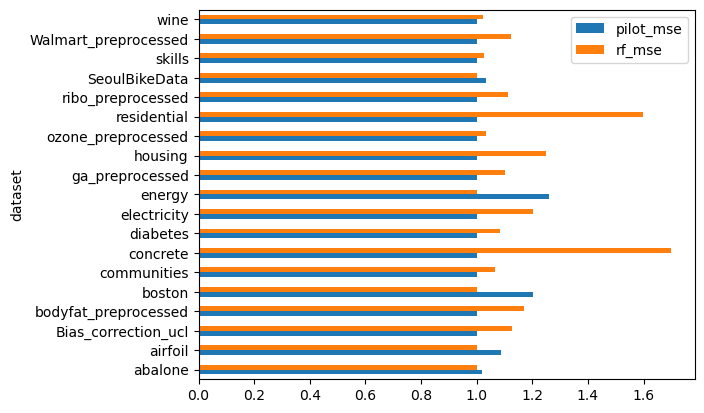

In [ ]:
normalized_results = pd.DataFrame([{
    'dataset': d, 
    'pilot_mse': -np.nanmax(r['pilot']['mean_test_score']), 
    'rf_mse': -np.nanmax(r['rf']['mean_test_score'])
    } for d, r in results.items()]).set_index('dataset').apply(lambda row: row / row.min(), axis=1)

normalized_results.plot.barh()

In [ ]:
normalized_results.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')


,pilot_mse,rf_mse
dataset,,
abalone,1.021,1.000
airfoil,1.088,1.000
Bias_correction_ucl,1.000,1.128
bodyfat_preprocessed,1.000,1.170
boston,1.203,1.000
communities,1.000,1.067
concrete,1.000,1.698
diabetes,1.000,1.082
electricity,1.000,1.202


#### Deep dive max depth

In [ ]:
max_depth_results = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_max_depth'])['mean_test_score'].mean().unstack()
max_depth_results *= -1
max_depth_results = max_depth_results.apply(lambda row: row / row.min(), axis=1)
max_depth_results.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_max_depth,2,10
dataset,,
Bias_correction_ucl,1.013,1.000
SeoulBikeData,2.423,1.000
Walmart_preprocessed,2.341,1.000
abalone,1.055,1.000
airfoil,1.642,1.000
bodyfat_preprocessed,1.022,1.000
boston,1.489,1.000
communities,1.064,1.000
concrete,1.374,1.000


#### Deep dive min samples split

In [ ]:
df = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_min_sample_split'])['mean_test_score'].mean().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_min_sample_split,2,10
dataset,,
Bias_correction_ucl,1.012,1.000
SeoulBikeData,1.000,1.024
Walmart_preprocessed,1.005,1.000
abalone,1.000,1.001
airfoil,1.000,1.003
bodyfat_preprocessed,1.008,1.000
boston,1.000,1.003
communities,1.000,1.001
concrete,1.000,1.001


#### Deep dive max depth &  min samples split

In [ ]:
df = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_min_sample_split', 'param_max_depth'])['mean_test_score'].mean().unstack().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

In [33]:
df = pd.concat([pd.DataFrame(results[d]['rf']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_min_samples_split', 'param_max_depth'])['mean_test_score'].mean().unstack().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

In [ ]:
pd.DataFrame(results['abalone']['pilot'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_sample_leaf,param_min_sample_split,param_n_estimators,param_n_features,param_truncation_factor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.796281,2.020451,3.349500,0.400117,2,1,2,50,1.0,1.5,"{'max_depth': 2, 'min_sample_leaf': 1, 'min_sa...",-10.939442,-2.952053,-5.577138,-3.632847,-3.987102,-5.417716,2.892293,3
1,23.323216,1.119977,3.201397,0.449936,2,1,10,50,1.0,1.5,"{'max_depth': 2, 'min_sample_leaf': 1, 'min_sa...",-10.883988,-2.978976,-5.577490,-3.598518,-4.017543,-5.411303,2.867852,2
2,30.396328,3.130993,3.313691,1.698185,10,1,2,50,1.0,1.5,"{'max_depth': 10, 'min_sample_leaf': 1, 'min_s...",-10.188859,-2.682452,NaN,-3.416042,-3.750725,NaN,NaN,4
3,30.004525,1.881924,3.321904,0.246008,10,1,10,50,1.0,1.5,"{'max_depth': 10, 'min_sample_leaf': 1, 'min_s...",-10.105636,-2.691930,-5.310696,-3.411045,-3.682005,-5.040262,2.673762,1


## Investigate max_depth vs n_estimators

### Run grid

In [8]:
OUTPUTPATH = pathlib.Path().absolute() / 'Output'

filename = OUTPUTPATH / 'rf_gridsearch_max_depth_n_estimators_n_features.pkl'

In [9]:
if filename.exists():
    results = joblib.load(filename)
else:
    results = {}

In [10]:
results.keys()

dict_keys(['abalone', 'airfoil', 'Bias_correction_ucl', 'bodyfat_preprocessed', 'boston', 'communities', 'concrete', 'diabetes', 'electricity', 'energy', 'ga_preprocessed', 'housing', 'ozone_preprocessed', 'residential'])

In [11]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (d, data) in enumerate(datasets.items()):
    print(i)
    if d == 'superconductor' or d in results.keys():
        continue
    pilot = GridSearchCV(
        estimator=ensemble.RandomForestPilot(),
        param_grid={
            'n_estimators': [50, 100],
            'max_depth': [5, 10],
            'truncation_factor': [1.5],
            'min_sample_split': [2],
            'min_sample_leaf':  [1],
            'n_features': [0.7, 1.0],
            'rel_tolerance': [0.01]
        }, 
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1
    )
    tree = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'n_estimators': [50, 100],
            'max_depth': [5, 10],
            'min_samples_split': [2],
            'min_samples_leaf':  [1],
            'max_features': [0.7, 1.0]
        },
        scoring='neg_mean_squared_error', 
        cv=cv,
        n_jobs=-1
    )

    X, y = data['data']
    
    pilot.fit(X, y, categorical_idx=np.array(data['categorical']))
    tree.fit(X, y)

    
    print(d, round(pilot.best_score_, 2), round(tree.best_score_, 2))
    
    results[d] = {'pilot': pilot.cv_results_, 'rf': tree.cv_results_}
    joblib.dump(results, filename)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
item(): can only convert an array of size 1 to a Python scalar
item(): can only convert an array of size 1 to a Python scalar
item(): can only convert an array of size 1 to a Python scalar
item(): can only convert an array of size 1 to a Python scalar
item(): can only convert an array of size 1 to a Python scalar
ribo_preprocessed -0.41 -0.45
15


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

item(): can only convert an array of size 1 to a Python scalar
item(): can only convert an array of size 1 to a Python scalar
item(): can only convert an array of size 1 to a Python scalar
SeoulBikeData -41582.6 -46330.07
16
skills -0.83 -0.85
17
18
Walmart_preprocessed -16070730874.47 -18616552794.52
19
wine -0.47 -0.42


### Inspect results

In [34]:
results = joblib.load( OUTPUTPATH / 'rf_gridsearch_max_depth_n_estimators_n_features.pkl')

<AxesSubplot: ylabel='dataset'>

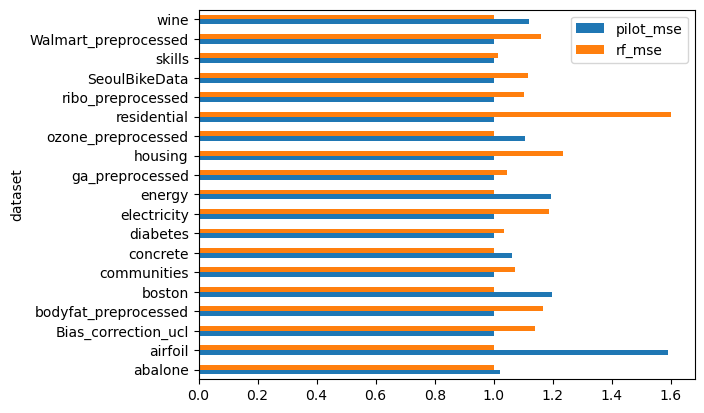

In [13]:
normalized_results = pd.DataFrame([{
    'dataset': d, 
    'pilot_mse': -np.nanmax(r['pilot']['mean_test_score']), 
    'rf_mse': -np.nanmax(r['rf']['mean_test_score'])
    } for d, r in results.items()]).set_index('dataset').apply(lambda row: row / row.min(), axis=1)

normalized_results.plot.barh()

In [16]:
normalized_results.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')


,pilot_mse,rf_mse
dataset,,
abalone,1.022,1.000
airfoil,1.589,1.000
Bias_correction_ucl,1.000,1.140
bodyfat_preprocessed,1.000,1.166
boston,1.199,1.000
communities,1.000,1.073
concrete,1.061,1.000
diabetes,1.000,1.035
electricity,1.000,1.188


#### Deep dive max depth

In [17]:
max_depth_results = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_max_depth'])['mean_test_score'].mean().unstack()
max_depth_results *= -1
max_depth_results = max_depth_results.apply(lambda row: row / row.min(), axis=1)
max_depth_results.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_max_depth,5,10
dataset,,
Bias_correction_ucl,1.653,1.000
SeoulBikeData,2.025,1.000
Walmart_preprocessed,1.179,1.000
abalone,1.005,1.000
airfoil,1.111,1.000
bodyfat_preprocessed,1.000,1.007
boston,1.054,1.000
communities,1.006,1.000
concrete,1.141,1.000


In [20]:
max_depth_results = pd.concat([pd.DataFrame(results[d]['rf']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_max_depth'])['mean_test_score'].mean().unstack()
max_depth_results *= -1
max_depth_results = max_depth_results.apply(lambda row: row / row.min(), axis=1)
max_depth_results.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_max_depth,5,10
dataset,,
Bias_correction_ucl,1.938,1.000
SeoulBikeData,2.100,1.000
Walmart_preprocessed,4.914,1.000
abalone,1.058,1.000
airfoil,3.115,1.000
bodyfat_preprocessed,1.025,1.000
boston,1.084,1.000
communities,1.025,1.000
concrete,1.746,1.000


#### Deep dive n_estimators

In [21]:
df = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_n_estimators'])['mean_test_score'].mean().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_n_estimators,50,100
dataset,,
Bias_correction_ucl,1.006,1.000
SeoulBikeData,1.002,1.000
Walmart_preprocessed,1.000,1.003
abalone,1.001,1.000
airfoil,1.012,1.000
bodyfat_preprocessed,1.000,1.001
boston,1.009,1.000
communities,1.000,1.003
concrete,1.000,1.001


In [22]:
df = pd.concat([pd.DataFrame(results[d]['rf']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_n_estimators'])['mean_test_score'].mean().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_n_estimators,50,100
dataset,,
Bias_correction_ucl,1.009,1.000
SeoulBikeData,1.000,1.002
Walmart_preprocessed,1.004,1.000
abalone,1.002,1.000
airfoil,1.000,1.005
bodyfat_preprocessed,1.026,1.000
boston,1.016,1.000
communities,1.012,1.000
concrete,1.018,1.000


#### Deep dive n_features

In [23]:
df = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_n_features'])['mean_test_score'].mean().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_n_features,0.700000,1.000000
dataset,,
Bias_correction_ucl,1.000,1.086
SeoulBikeData,1.000,1.022
Walmart_preprocessed,1.016,1.000
abalone,1.014,1.000
airfoil,1.452,1.000
bodyfat_preprocessed,1.000,1.019
boston,1.000,1.023
communities,1.004,1.000
concrete,1.021,1.000


In [25]:
df = pd.concat([pd.DataFrame(results[d]['rf']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_max_features'])['mean_test_score'].mean().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_max_features,0.700000,1.000000
dataset,,
Bias_correction_ucl,1.000,1.057
SeoulBikeData,1.013,1.000
Walmart_preprocessed,1.073,1.000
abalone,1.002,1.000
airfoil,1.033,1.000
bodyfat_preprocessed,1.004,1.000
boston,1.000,1.052
communities,1.000,1.021
concrete,1.015,1.000


#### Deep dive max depth &  n_features & n_estimators

In [36]:
df = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_n_estimators', 'param_max_depth'])['mean_test_score'].mean().unstack().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

In [ ]:
df = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_n_estimators', 'param_max_depth', 'param_n_features'])['mean_test_score'].mean().unstack().unstack().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

In [37]:
df = pd.concat([pd.DataFrame(results[d]['rf']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_n_estimators', 'param_max_depth'])['mean_test_score'].mean().unstack().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

In [30]:
df = pd.concat([pd.DataFrame(results[d]['rf']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_n_estimators', 'param_max_depth', 'param_max_features'])['mean_test_score'].mean().unstack().unstack().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

# Investigate bad performance

## Airfoil

### Impact of cv random seed

In [10]:
data = datasets['airfoil']
results = {}
for seed in range(5):
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    pilot = GridSearchCV(
        estimator=ensemble.RandomForestPilot(),
        param_grid={
            'n_estimators': [50, 100],
            'max_depth': [5, 10],
            'truncation_factor': [1.5],
            'min_sample_split': [2],
            'min_sample_leaf':  [1],
            'n_features': [0.7, 1.0],
            'rel_tolerance': [0.01]
        }, 
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=-1
    )
    tree = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'n_estimators': [50, 100],
            'max_depth': [5, 10],
            'min_samples_split': [2],
            'min_samples_leaf':  [1],
            'max_features': [0.7, 1.0]
        },
        scoring='neg_mean_squared_error', 
        cv=cv,
        n_jobs=-1
    )

    X, y = data['data']
    
    pilot.fit(X, y, categorical_idx=np.array(data['categorical']))
    tree.fit(X, y)

    
    print(seed, round(pilot.best_score_, 2), round(tree.best_score_, 2))
    
    results[seed] = {'pilot': dict(model=pilot, **pilot.cv_results_), 'rf': dict(model=tree, **tree.cv_results_)}

0 -7.1 -3.93
1 -6.85 -3.86
2 -6.73 -4.06
3 -7.0 -4.06
4 -7.14 -3.93


In [30]:
scores_pilot = [
    score for seed in range(5) 
    for score in pd.DataFrame(
        results[seed]['pilot']
        ).sort_values('rank_test_score').iloc[0][[f'split{i}_test_score' for i in range(5)]].to_list()
]
scores_rf = [
    score for seed in range(5) 
    for score in pd.DataFrame(
        results[seed]['rf']
        ).sort_values('rank_test_score').iloc[0][[f'split{i}_test_score' for i in range(5)]].to_list()
]

Text(0.5, 0, 'Mean Squared Error on holdout set')

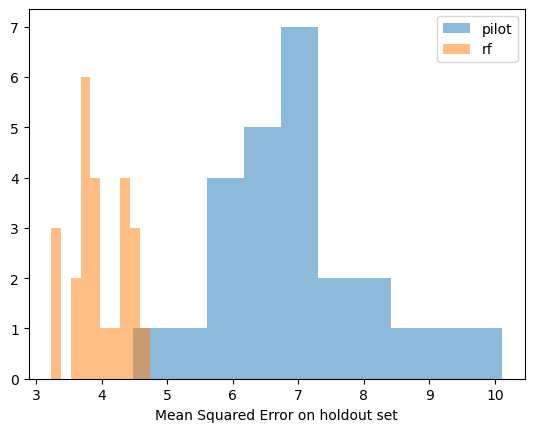

In [34]:
plt.hist(np.array(scores_pilot)*-1, label='pilot', alpha=0.5)
plt.hist(np.array(scores_rf)*-1, label='rf', alpha=0.5)
plt.legend()
plt.xlabel('Mean Squared Error on holdout set')

In [56]:
df = pd.json_normalize([dict(seed=seed, **{m: results[seed][m]['model'].best_params_ for m in ['pilot', 'rf']}) for seed in range(5)]).set_index('seed')
df.columns = df.columns.str.split('.', expand=True).swaplevel(0, 1)
df.rename(columns={'n_features': 'max_features', 'min_sample_split': 'min_samples_split', 'min_sample_leaf': 'min_samples_leaf'}, level=0, inplace=True)

df.sort_index(axis=1, level=[0, 1])

max_depth     max_features      min_samples_leaf    min_samples_split     \
         pilot  rf        pilot   rf            pilot rf             pilot rf   
seed                                                                            
0           10  10          1.0  1.0                1  1                 2  2   
1           10  10          1.0  1.0                1  1                 2  2   
2           10  10          1.0  1.0                1  1                 2  2   
3           10  10          1.0  1.0                1  1                 2  2   
4           10  10          1.0  1.0                1  1                 2  2   

     n_estimators      rel_tolerance truncation_factor  
            pilot   rf         pilot             pilot  
seed                                                    
0             100   50          0.01               1.5  
1             100  100          0.01               1.5  
2             100  100          0.01               1.5  
3              50  100          0.01               1.5  
4             100  100          0.01               1.5

### Individual tree performance

In [58]:
pilot = results[0]['pilot']['model'].best_estimator_
rf = results[0]['rf']['model'].best_estimator_

In [60]:
print(r2_score(data['data'][1], pilot.predict(data['data'][0])), mean_squared_error(data['data'][1], pilot.predict(data['data'][0])))
print(r2_score(data['data'][1], rf.predict(data['data'][0])), mean_squared_error(data['data'][1], rf.predict(data['data'][0])))

0.898275755307805 4.8379846177275345
0.972576113157232 1.3042745424659992


In [61]:
for seed in range(5):
    X_train, X_test, y_train, y_test = train_test_split(*data['data'], test_size=0.2, random_state=seed)

    pilot.fit(X_train, y_train, categorical_idx=np.array(data['categorical']))
    rf.fit(X_train, y_train)
    
    print(seed, r2_score(y_test, pilot.predict(X_test)), mean_squared_error(y_test, pilot.predict(X_test)))
    print(seed, r2_score(y_test, rf.predict(X_test)), mean_squared_error(y_test, rf.predict(X_test)))

0 0.8689225651385521 6.165752750848211
0 0.9205973079728951 3.735024013159635
1 0.848143599913359 6.449918838321802
1 0.9197415523263932 3.408881504428604
2 0.8387749370636574 8.338335942348055
2 0.9102472632279787 4.641886672705098
3 0.8622061946480253 6.013451799580648
3 0.893413219548698 4.651547760649778
4 0.8814338171349563 5.696556870106151
4 0.9158790650510196 4.0416219728420275


Text(0.5, 0, 'Mean Squared Error on holdout set for individual trees')

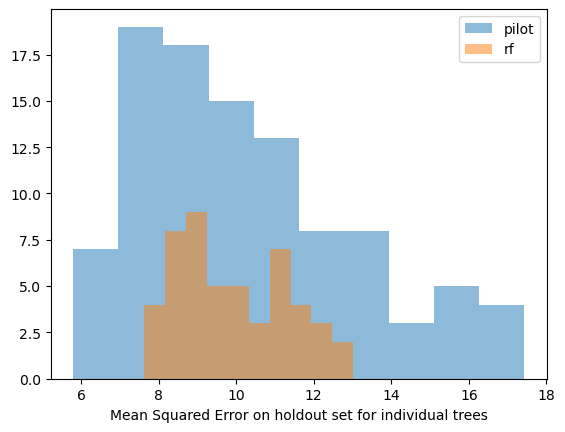

In [65]:
pilot_tree_scores = [mean_squared_error(y_test, t.predict(X_test)) for t in pilot.estimators]
rf_tree_scores = [mean_squared_error(y_test, t.predict(X_test)) for t in rf.estimators_]

plt.hist(pilot_tree_scores, label='pilot', alpha=0.5)
plt.hist(rf_tree_scores, label='rf', alpha=0.5)
plt.legend()
plt.xlabel('Mean Squared Error on holdout set for individual trees')

### Impact of max_depth

In [77]:
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)
for max_depth in [2, 5, 10, 15, 20, 30, 50]:
    pilot.max_depth = max_depth
    rf.max_depth = max_depth
    
    pilot_score = -1 * cross_val_score(pilot, *data['data'], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    rf_score = -1 * cross_val_score(rf, *data['data'], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    
    results.append({'max_depth': max_depth, 'pilot': pilot_score, 'rf': rf_score})
    

<AxesSubplot: xlabel='max_depth', ylabel='mse'>

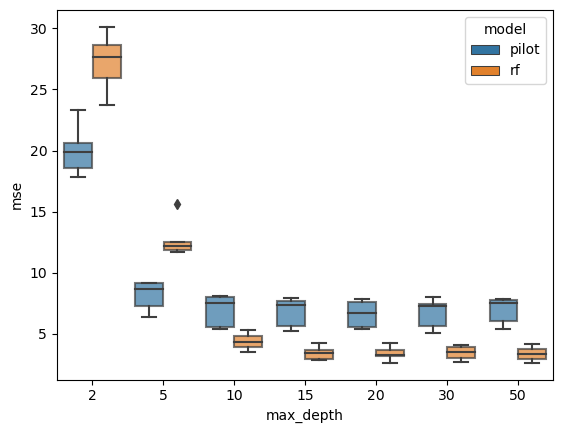

In [81]:
df = pd.DataFrame(results).explode(['pilot', 'rf']).melt(id_vars='max_depth', value_vars=['pilot', 'rf'], var_name='model', value_name='mse')
sns.boxplot(data=df, x='max_depth', y='mse', hue='model', boxprops=dict(alpha=.7))

### Effective max depth of individual trees

## Walmart

In [ ]:
pd.read_csv(DATAPATH / 'Walmart_preprocessed.csv')

,Store,target,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,4,2,1
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,4,2,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,1
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,1
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,4,3,1
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,4,9,3
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,4,10,3
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,4,10,3
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,4,10,3


In [ ]:
X[:5]

array([[  1.       ,   0.       ,  42.31     ,   2.572    , 211.0963582,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   1.       ,  38.51     ,   2.548    , 211.2421698,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   0.       ,  39.93     ,   2.514    , 211.2891429,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   0.       ,  46.63     ,   2.561    , 211.3196429,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   0.       ,  46.5      ,   2.625    , 211.3501429,
          8.106    ,   4.       ,   3.       ,   1.       ]])

In [ ]:
X, y = datasets['Walmart_preprocessed']['data']
categorical = datasets['Walmart_preprocessed']['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

np.random.seed(101)
scores = cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error')
p_mse = -np.mean(scores)
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

2.7791366601220706 1.0


In [ ]:
cv = KFold(5, shuffle=True)
scores = []
for train_idx, test_idx in cv.split(X):
    p = Pilot.PILOT()
    p.fit(X[train_idx, :], y[train_idx], categorical=np.array(categorical))
    scores.append(mean_squared_error(y[test_idx], p.predict(X[test_idx])))

[f'{m:.2e}' for m in scores]
    

['1.64e+10', '1.58e+10', '1.76e+10', '1.99e+10', '1.93e+10']

In [ ]:
X_enc = OneHotEncoder().fit_transform(X[:, [0]]).toarray()
X_enc = np.hstack([X_enc, X[:, 1:]])
print(X.shape, X_enc.shape)

p2_mse = -np.mean(cross_val_score(d, X_enc, y, scoring='neg_mean_squared_error'))
d2_mse = -np.mean(cross_val_score(d, X_enc, y, scoring='neg_mean_squared_error'))
print(p_mse / min(p_mse, d_mse, d2_mse, p2_mse), p2_mse / min(p_mse, d_mse, d2_mse, p2_mse), d_mse / min(p_mse, d_mse, d2_mse, p2_mse), d2_mse / (min(p_mse, d_mse, d2_mse, p2_mse)))

(6435, 9) (6435, 53)
2.788660598687874 1.013677496545187 1.0 1.0136774965451865


In [ ]:
f'{p_mse:.2e}, {p2_mse:.2e}, {d2_mse:.2e}'

'1.42e+12, 5.15e+11, 5.15e+11'

## Electricity

In [ ]:
dname = 'electricity'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.8729348495313307


In [ ]:
results['electricity']['pilot']['mean_test_score'], results['electricity']['rf']['mean_test_score']

(array([-0.00049177, -0.00048808,         nan,         nan]),
 array([-0.0009364 , -0.00092756, -0.00016658, -0.00016975]))

In [ ]:
prf = ensemble.RandomForestPilot(n_estimators=50, max_depth=10, min_sample_split=2, truncation_factor=1.5)
results = cross_validate(prf, X, y, scoring='neg_mean_squared_error', n_jobs=-1, fit_params={'categorical_idx': np.array(categorical)}, return_estimator=True)


In [ ]:
p = Pilot.PILOT(max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0.01)
bootstrap_idx = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
p.fit(X[bootstrap_idx, :], y[bootstrap_idx], categorical=np.array(categorical))

p.model_tree.nodes_selected()

{'con': 2, 'lin': 4, 'blin': 5, 'pcon': 1, 'plin': 0}

## Boston

In [ ]:
dname = 'boston'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.1748315721418028


In [ ]:
for i in range(100):
    p = Pilot.PILOT(max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0.00)
    bootstrap_idx = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
    p.fit(X[bootstrap_idx, :], y[bootstrap_idx], categorical=np.array(categorical))

7 blin {'con': 0, 'lin': 0, 'blin': 1, 'pcon': 0, 'plin': 0} {'lin': 2963, 'blin': 10, 'pcon': 1, 'plin': 3, 'pconc': 1}


Exception: 

## Skills

In [ ]:
dname = 'skills'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.4863177817216304


## Wine

In [ ]:
dname = 'wine'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.3978899488124397


## Abalone

In [ ]:
dname = 'abalone'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.2649648675728686


In [ ]:
for i in range(100):
    p = Pilot.PILOT(max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0.00)
    bootstrap_idx = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
    p.fit(X[bootstrap_idx, :], y[bootstrap_idx], categorical=np.array(categorical))

In [ ]:
rfp = ensemble.RandomForestPilot(n_estimators=50, max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0)
for train_idx, test_idx in KFold().split(X, y):
    rfp.fit(X[train_idx, :], y[train_idx])
    print(r2_score(y[test_idx], rfp.predict(X[test_idx, :])))

0.4098002559030295
0.2847848498919635
0.5401221094057291
0.5656876172648391
0.48212196709914723


## Bike

In [ ]:
dname = 'SeoulBikeData'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0587370965296532 1.0


In [ ]:
datasets[dname]['categorical']

[-1]

## California

In [ ]:
dname = 'housing'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.252993057125518


## Communities

In [ ]:
dname = 'communities'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.4973791251675714


In [ ]:
for i in range(100):
    p = Pilot.PILOT(max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0.00)
    bootstrap_idx = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
    p.fit(X[bootstrap_idx, :], y[bootstrap_idx], categorical=np.array(categorical))

6 plin {'con': 1, 'lin': 29, 'blin': 1, 'pcon': 0, 'plin': 1} {'lin': 3341, 'blin': 21, 'pcon': 5, 'plin': 10, 'pconc': 0}


Exception: 

In [ ]:
rfp = ensemble.RandomForestPilot(n_estimators=50, max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0)
for train_idx, test_idx in KFold().split(X, y):
    rfp.fit(X[train_idx, :], y[train_idx])
    print(r2_score(y[test_idx], rfp.predict(X[test_idx, :])))

0.4098002559030295
0.2847848498919635
0.5401221094057291
0.5656876172648391
0.48212196709914723
